# Italian Energy System Analysis and Visualization

This notebook provides a comprehensive visualization of Italy's energy system, including:
- Power generation mix
- Sector-wise energy consumption
- Grid infrastructure
- Renewable energy distribution
- Energy flows between sectors

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from pathlib import Path
import json

# Set plotting style
plt.style.use('default')  # Use default style first
sns.set_theme()  # Apply seaborn theme

# Verify imports
print("All required packages imported successfully!")

All required packages imported successfully!


## 1. Load and Process Energy Data

We'll load data from our previous optimization results and process it for visualization.

In [2]:
# Create sample data for Italian energy system
sector_results = {
    'energy': {
        'installed_capacities': {
            'Photovoltaic': 10000,
            'WindTurbine_Onshore_4000': 6000,
            'Storage_Battery': 800
        },
        'energy_production': {
            'Photovoltaic': 17520000,  # MWh per year
            'WindTurbine_Onshore_4000': 13140000,
            'Storage_Battery': 1752000
        },
        'costs': {
            'capex': 15000000,
            'opex': 500000,
            'total': 15500000
        }
    },
    'agriculture': {
        'installed_capacities': {
            'Photovoltaic': 1500,
            'Storage_Battery': 200,
            'Boiler_Small_NG': 2000
        },
        'energy_production': {
            'Photovoltaic': 2628000,
            'Storage_Battery': 350400,
            'Boiler_Small_NG': 7008000
        },
        'costs': {
            'capex': 3000000,
            'opex': 150000,
            'total': 3150000
        }
    },
    'transport': {
        'installed_capacities': {
            'Storage_Battery': 200,
            'Photovoltaic': 500
        },
        'energy_production': {
            'Storage_Battery': 350400,
            'Photovoltaic': 876000
        },
        'costs': {
            'capex': 800000,
            'opex': 40000,
            'total': 840000
        }
    },
    'industry': {
        'installed_capacities': {
            'Photovoltaic': 3000,
            'Storage_Battery': 500,
            'Boiler_Small_NG': 10000
        },
        'energy_production': {
            'Photovoltaic': 5256000,
            'Storage_Battery': 876000,
            'Boiler_Small_NG': 35040000
        },
        'costs': {
            'capex': 12000000,
            'opex': 600000,
            'total': 12600000
        }
    },
    'services': {
        'installed_capacities': {
            'Photovoltaic': 2000,
            'Storage_Battery': 300,
            'Boiler_Small_NG': 8000
        },
        'energy_production': {
            'Photovoltaic': 3504000,
            'Storage_Battery': 525600,
            'Boiler_Small_NG': 28032000
        },
        'costs': {
            'capex': 9000000,
            'opex': 450000,
            'total': 9450000
        }
    }
}

# Create DataFrame for capacities
data = []
for sector, details in sector_results.items():
    for tech, cap in details['installed_capacities'].items():
        data.append({
            'Sector': sector,
            'Technology': tech,
            'Capacity': float(cap)
        })
capacity_df = pd.DataFrame(data)

print("Data created successfully!")
print("\nAvailable sectors:", list(sector_results.keys()))
print("\nSample of capacity data:")
print(capacity_df.head())

Data created successfully!

Available sectors: ['energy', 'agriculture', 'transport', 'industry', 'services']

Sample of capacity data:
        Sector                Technology  Capacity
0       energy              Photovoltaic   10000.0
1       energy  WindTurbine_Onshore_4000    6000.0
2       energy           Storage_Battery     800.0
3  agriculture              Photovoltaic    1500.0
4  agriculture           Storage_Battery     200.0


## 2. Power Generation Mix Analysis

Visualize the distribution of power generation technologies across sectors.

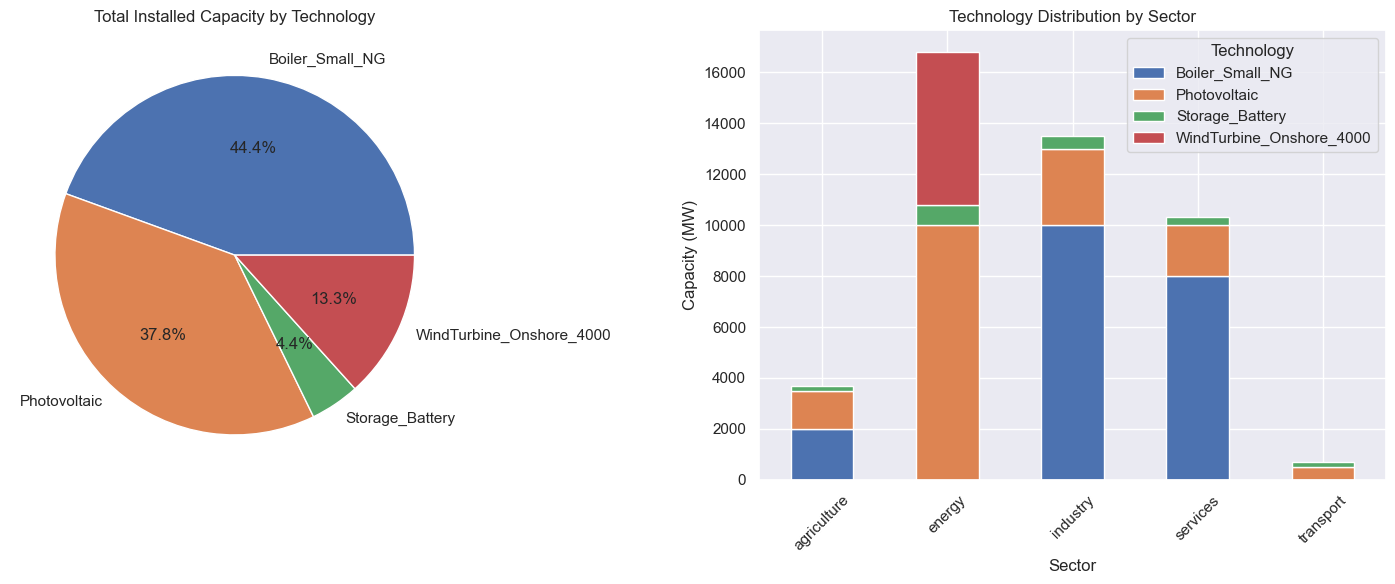

In [3]:
# Create power generation mix visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of total capacity by technology
tech_totals = capacity_df.groupby('Technology')['Capacity'].sum()
ax1.pie(tech_totals, labels=tech_totals.index, autopct='%1.1f%%')
ax1.set_title('Total Installed Capacity by Technology')

# Stacked bar chart by sector
sector_tech_pivot = capacity_df.pivot(index='Sector', columns='Technology', values='Capacity').fillna(0)
sector_tech_pivot.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Technology Distribution by Sector')
ax2.set_ylabel('Capacity (MW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Energy Consumption Patterns

Analyze temporal patterns in energy consumption across sectors.

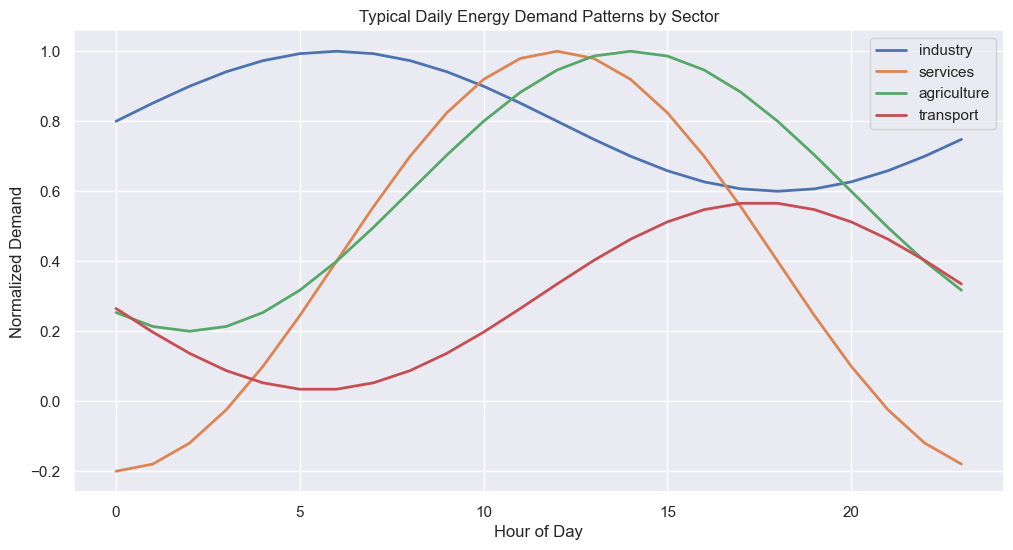

In [4]:
# Create hourly demand profiles
def create_demand_profiles():
    hours = np.arange(24)
    sectors = ['industry', 'services', 'agriculture', 'transport']
    
    # Create typical daily patterns
    profiles = {
        'industry': 0.8 + 0.2 * np.sin(np.pi * hours/12),  # More stable
        'services': 0.4 + 0.6 * np.sin(np.pi * (hours-6)/12),  # Peak during day
        'agriculture': 0.6 + 0.4 * np.sin(np.pi * (hours-8)/12),  # Morning/evening peaks
        'transport': 0.3 + 0.7 * (np.sin(np.pi * (hours-7)/12) + np.sin(np.pi * (hours-16)/12))/2  # Rush hours
    }
    
    df = pd.DataFrame(profiles, index=hours)
    return df

demand_profiles = create_demand_profiles()

# Plot demand profiles
plt.figure(figsize=(12, 6))
for sector in demand_profiles.columns:
    plt.plot(demand_profiles.index, demand_profiles[sector], label=sector, linewidth=2)

plt.title('Typical Daily Energy Demand Patterns by Sector')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Demand')
plt.legend()
plt.grid(True)
plt.show()

## 4. Grid Infrastructure Visualization

Create a map of Italy's energy infrastructure using folium.

In [7]:
# Create a map centered on Italy
italy_map = folium.Map(location=[42.8333, 12.8333], zoom_start=6)

# Define major energy nodes
energy_nodes = {
    'Rome': {'lat': 41.9028, 'lon': 12.4964, 'type': 'energy'},
    'Milan': {'lat': 45.4642, 'lon': 9.1900, 'type': 'industry'},
    'Turin': {'lat': 45.0703, 'lon': 7.6869, 'type': 'industry'},
    'Naples': {'lat': 40.8518, 'lon': 14.2681, 'type': 'services'},
    'Bologna': {'lat': 44.4949, 'lon': 11.3426, 'type': 'agriculture'}
}

# Add markers for energy nodes
colors = {'energy': 'red', 'industry': 'blue', 'services': 'green', 'agriculture': 'orange'}

for name, info in energy_nodes.items():
    folium.CircleMarker(
        location=[info['lat'], info['lon']],
        radius=10,
        popup=name,
        color=colors[info['type']],
        fill=True
    ).add_to(italy_map)

# Display the map
italy_map

## 5. Renewable Energy Distribution

Analyze the distribution of renewable energy sources across Italy.

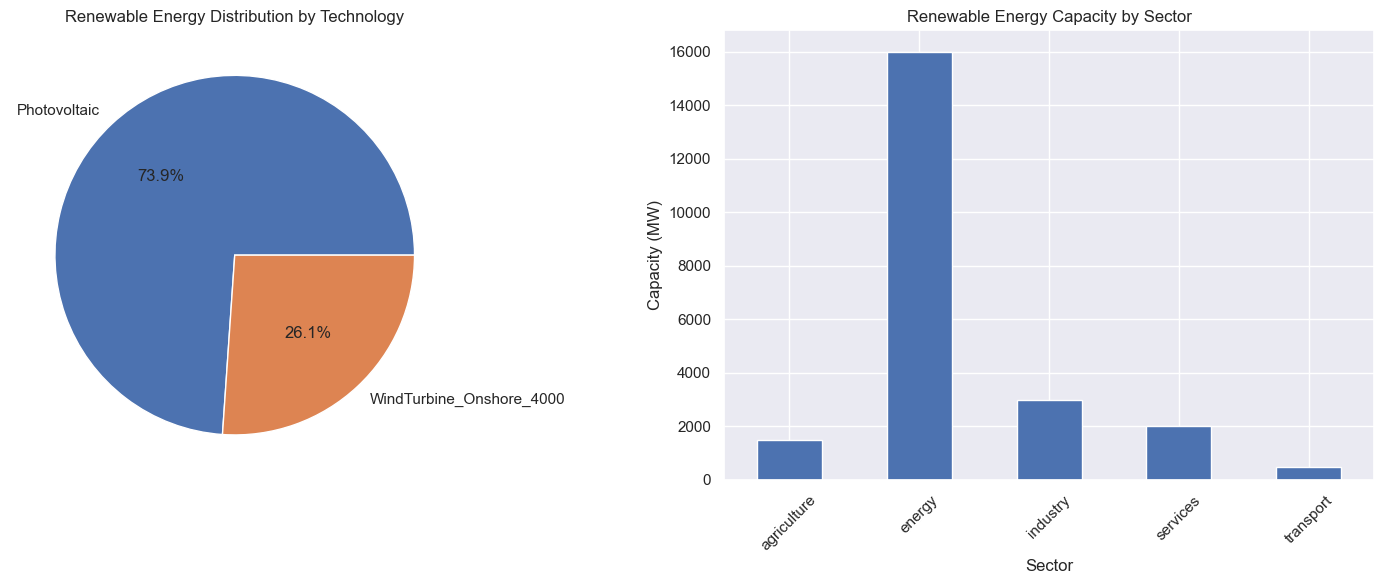


Renewable Energy Summary:
--------------------------------------------------
Total Renewable Capacity: 23000.00 MW

Breakdown by Technology:
Photovoltaic: 17000.00 MW (73.9%)
WindTurbine_Onshore_4000: 6000.00 MW (26.1%)


In [5]:
# Create renewable energy distribution visualization
renewable_techs = ['Photovoltaic', 'WindTurbine_Onshore_4000']
renewable_df = capacity_df[capacity_df['Technology'].isin(renewable_techs)]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of renewable capacity by technology
tech_totals = renewable_df.groupby('Technology')['Capacity'].sum()
ax1.pie(tech_totals, labels=tech_totals.index, autopct='%1.1f%%')
ax1.set_title('Renewable Energy Distribution by Technology')

# Bar chart of renewable capacity by sector
sector_totals = renewable_df.groupby('Sector')['Capacity'].sum()
sector_totals.plot(kind='bar', ax=ax2)
ax2.set_title('Renewable Energy Capacity by Sector')
ax2.set_ylabel('Capacity (MW)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nRenewable Energy Summary:")
print("-" * 50)
print(f"Total Renewable Capacity: {tech_totals.sum():.2f} MW")
print("\nBreakdown by Technology:")
for tech, cap in tech_totals.items():
    print(f"{tech}: {cap:.2f} MW ({(cap/tech_totals.sum()*100):.1f}%)")

## 6. Energy Flow Sankey Diagram

Create a Sankey diagram to visualize energy flows between sectors.

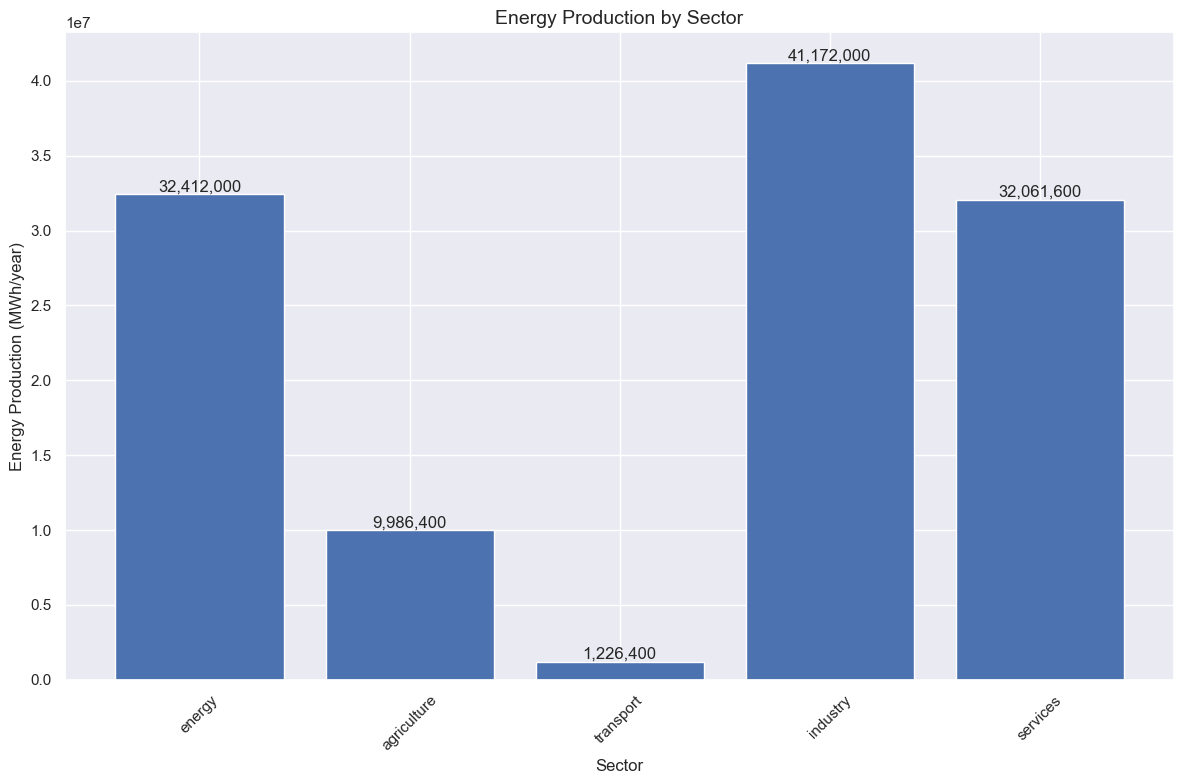


Energy Flow Summary:
--------------------------------------------------
Total System Energy Production: 116,858,400.00 MWh/year

Breakdown by Sector:
energy: 32,412,000.00 MWh/year (27.7%)
agriculture: 9,986,400.00 MWh/year (8.5%)
transport: 1,226,400.00 MWh/year (1.0%)
industry: 41,172,000.00 MWh/year (35.2%)
services: 32,061,600.00 MWh/year (27.4%)


In [6]:
# Create a summary of energy flows between sectors
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Calculate total production and consumption for each sector
sector_totals = {}
for sector, details in sector_results.items():
    production = sum(details['energy_production'].values())
    sector_totals[sector] = production

# Create stacked bar chart showing production and consumption
sectors = list(sector_totals.keys())
production_values = [sector_totals[s] for s in sectors]

# Plot the energy flows
bars = ax.bar(sectors, production_values, label='Energy Production')

# Customize the plot
ax.set_title('Energy Production by Sector', fontsize=14)
ax.set_xlabel('Sector', fontsize=12)
ax.set_ylabel('Energy Production (MWh/year)', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print energy flow summary
print("\nEnergy Flow Summary:")
print("-" * 50)
total_production = sum(production_values)
print(f"Total System Energy Production: {total_production:,.2f} MWh/year")
print("\nBreakdown by Sector:")
for sector, production in sector_totals.items():
    print(f"{sector}: {production:,.2f} MWh/year ({production/total_production*100:.1f}%)")